In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff6_new as ds
from copy import copy as dup
from scipy.integrate import odeint

In [2]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
#Setting up the system

nx = 501 # Number of points in simulation box
xmax = 50
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltaX = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot = np.ones(nx)
NQLL = ds.getNliq(Ntot,Nstar,Nbar)
Nice = Ntot-NQLL

<IPython.core.display.Javascript object>


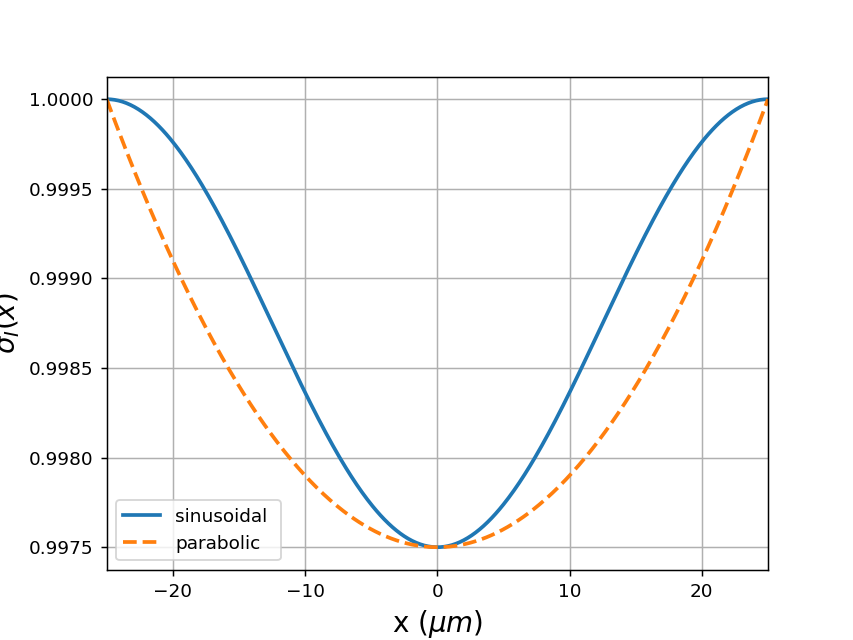

In [4]:
# Lay out the system
Ntot = NQLL + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltat = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltat = deprate * deltat

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid') #NOTE i think this should be nx not xmax
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic')
sigmastepstyle = 'sinusoid'
sigmastepstyle = 'parabolic'
if sigmastepstyle=='sinusoid':
    sigmastep = sigmastep_sinusoid
elif sigmastepstyle=='parabolic':
    sigmastep = sigmastep_parabolic
else:
    print('bad choice')

# Graph sigma(x)
plt.figure()
plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
         x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

In [5]:
# These are run control parameters

# Flag for explicit updating NQLL(Ntot) every step
updatingNQLL = False

# Set up a maximum number of iterations or layers
uselayers = True

# 0D run
if uselayers:
    layermax_0D = 100
else:
    countermax_0D = 100

# 1D run 
if uselayers:
    layermax_1D = 500
else:
    countermax_1D = 15000

In [6]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time)', dtmax)
print('deltat =', deltat)
print('deprate =', deprate, 'monolayers/us')
print('nmid', nmid)
print('N*', Nstar)
print('N*x2pi', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltaX', deltaX)
print('sigma_0 =', sigma0)
print('sigmastepmax =', sigmastepmax)
print('center reduction', center_reduction, '%')
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deltat_max (Diffusion time) 50.00000000000001
deltat = 1.0000000000000002
deprate = 0.16333333333333333 monolayers/us
nmid 250
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.1
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 0.25 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


<IPython.core.display.Javascript object>


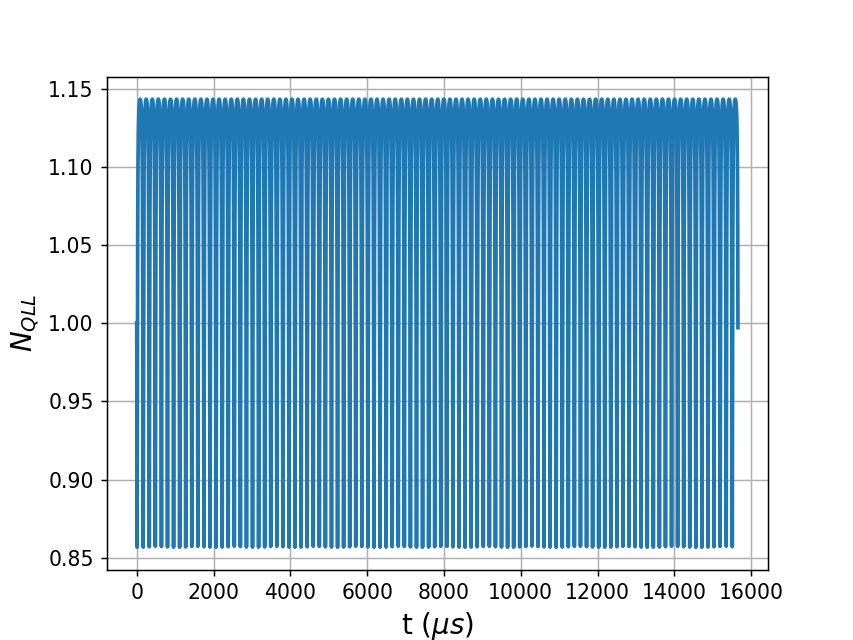

0-D Modeled growth rate, um/s 1.8970967656173623
0-D Modeled growth rate, ml/us 0.0063236558853912075
0-D Modeled alpha 0.19358130261401654


In [7]:
# This is the 0-d run
updatingNQLL = False

# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmastepmax, sigma0, deprate]

y0 = [Nbar,0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltat]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to NQLL
    NQLLlast, Ntotlast = ylast

    if updatingNQLL:
        NQLLlast = ds.getNliq(Ntotlast,Nstar,Nbar) # This updates NQLLlast and ylast!
        ykeep_0D[counter][0] = NQLLlast # Saves the updated NQLL for this step
    Nicelast = Ntotlast - NQLLlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    if uselayers:
        if layer > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)

tkeep_0D_False = tkeep_0D
ykeep_0Darr_False = ykeep_0Darr

<IPython.core.display.Javascript object>


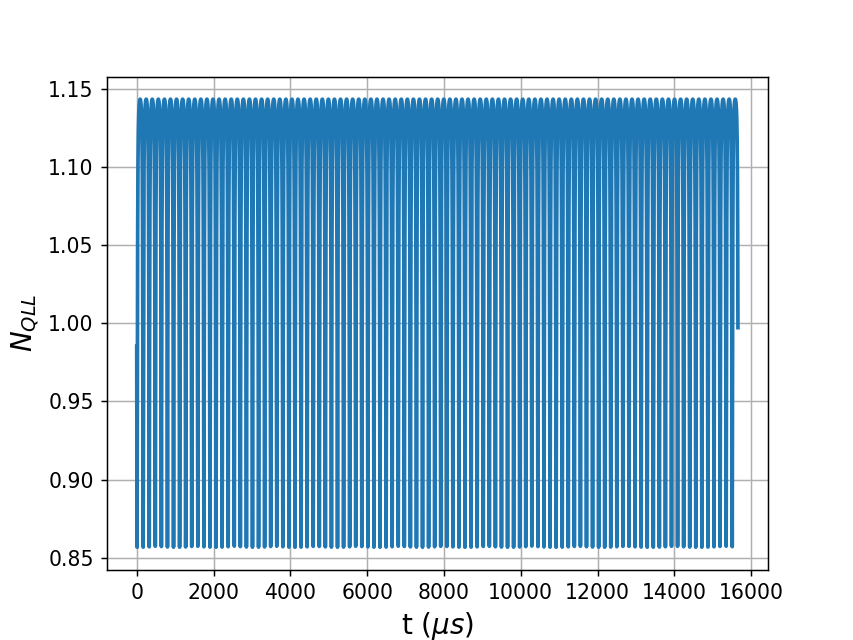

0-D Modeled growth rate, um/s 1.8970967656173623
0-D Modeled growth rate, ml/us 0.0063236558853912075
0-D Modeled alpha 0.19358130261401654


In [8]:
# This is the 0-d run, True
updatingNQLL = True

# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmastepmax, sigma0, deprate]

y0 = [Nbar,0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltat]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to NQLL
    NQLLlast, Ntotlast = ylast

    if updatingNQLL:
        NQLLlast = ds.getNliq(Ntotlast,Nstar,Nbar) # This updates NQLLlast and ylast!
        ykeep_0D[counter][0] = NQLLlast # Saves the updated NQLL for this step
    Nicelast = Ntotlast - NQLLlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    if uselayers:
        if layer > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)

tkeep_0D_True = tkeep_0D
ykeep_0Darr_True = ykeep_0Darr

<IPython.core.display.Javascript object>


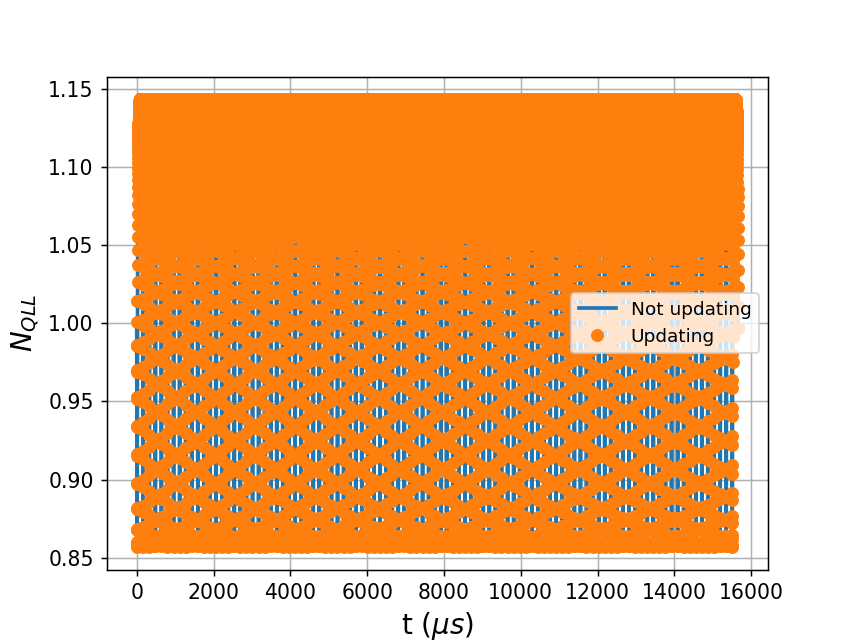

<IPython.core.display.Javascript object>


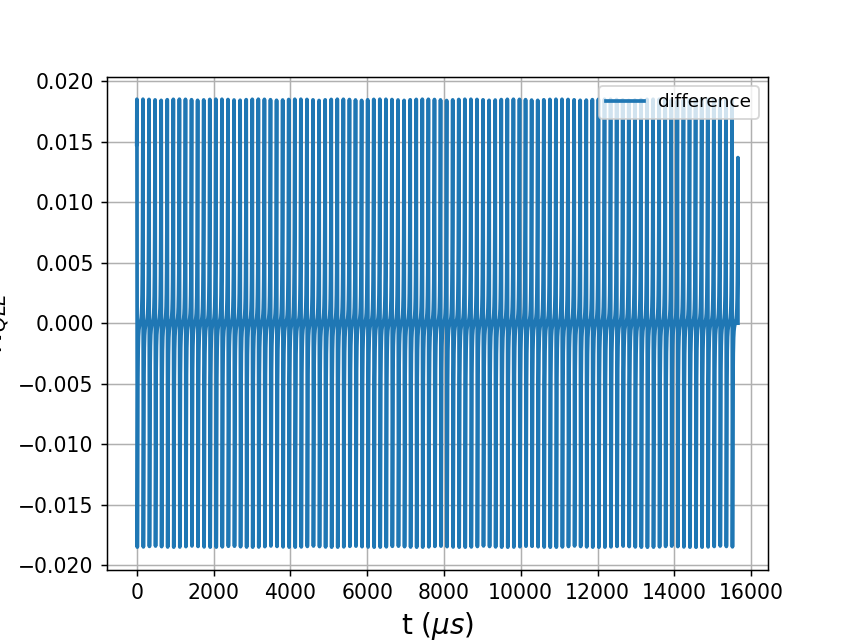

In [9]:
# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr_False[:,0],lw=linewidth,label='Not updating')
# plt.plot(tkeep_0D+deltat,ykeep_0Darr_True[:,0],'o',lw=linewidth)
plt.plot(tkeep_0D,ykeep_0Darr_True[:,0],'o',lw=linewidth,label='Updating')
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.legend()

plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr_False[:,0]-ykeep_0Darr_True[:,0],lw=linewidth,label='difference')
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.legend()

In [22]:
#Parameters for 1-D run 
L = xmax/2; print(L) # micrometers
c_r = center_reduction / 100; print(c_r) # dimensionless
nu_kin_ml = deprate; print(nu_kin_ml) # monolayers per microsecond
sigma_I = sigmastepmax; print(sigma_I) # dimensionless
print(D, 'um^2/us') # D is in micrometers^2/microsecond
print(D*1e-6, 'm^2/s') # reporting as meters^2/second
M = np.array([.0027, .0025])
B = np.array([2.9, 1.59])
beta = np.array([0.65, 0.65])
xfactor = nu_kin_ml*L**2*c_r**beta*sigma_I/D
NSS = M*xfactor + B
print('sinusoid:', NSS[0])
print('paraboloic:', NSS[1])

# This scales the surface diffusion coefficient
gamma = 0.002

25.0
0.0025
0.16333333333333333
0.2
0.0002 um^2/us
2e-10 m^2/s
sinusoid: 8.510216387742963
paraboloic: 6.784644803465706


In [11]:
# This is the 1-d run
updatingNQLL = False

# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmastep, sigma0, deprate, DoverdeltaX2, nx, gamma] 

# Initial conditions for ODE solver
y0 = np.array([NQLL,Ntot])
ylast = dup(y0)

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
NQLLkeep = [dup(NQLL)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
counter = 0
lastlayer = 0
lastdiff = 0

while True:
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)

    ylast = np.reshape(y[1],(2,nx))
    tlast += deltat
    counter += 1
        
    # Make some local copies, with possible updates to NQLL
    NQLL, Ntot = ylast
    if updatingNQLL:
        NQLL = ds.getNliq(Ntot,Nstar,Nbar) # This updates to remove any drift
        ylast[0] = NQLL
    Nice = Ntot - NQLL
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltat

    # Stuff into keeper arrays
    Nicekeep.append(Nice)
    Ntotkeep.append(Ntot)
    NQLLkeep.append(NQLL)
    tkeep.append(ttot)

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
    if uselayers:
        if layer > layermax_1D-1:
            print('breaking because reached max number of layers')
            break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

0 0 0.00014918604022551296
158 1 0.11505068318574341
316 2 0.18670406793690697
474 3 0.23262653856770843
632 4 0.263186389807065
790 5 0.2841387714102641
949 6 0.3257786675280059
1107 7 0.33624517404797505
1265 8 0.3433842377047167
1423 9 0.3481083385909134
1581 10 0.3510423852119775
1740 11 0.3814134068143531
1898 12 0.38139236793587905
2056 13 0.38052321811538903
2215 14 0.40876755196025627
2373 15 0.40597652192209566
2531 16 0.4027801128610342
2689 17 0.399297568079497
2848 18 0.42496657922150405
3006 19 0.42027431579345986
3164 20 0.4155736925379827
3323 21 0.44023026142238564
3481 22 0.4347140395480764
3639 23 0.42944628861381773
3798 24 0.4533531422355068
3956 25 0.4476641541414317
4115 26 0.47180460372967303
4273 27 0.4659457853387714
4431 28 0.4607739162707709
4590 29 0.484581016975568
4748 30 0.4794674434096322
4907 31 0.5033277667518483
5065 32 0.4973958945302144
5224 33 0.5198119554679934
5382 34 0.5119162031678357
5541 35 0.5416931811487302
5699 36 0.6039949804608256
5858 3

46892 294 5.3163927532453386
47053 295 5.329620022681695
47214 296 5.342761608769763
47374 297 5.327061416803531
47535 298 5.3390092809086696
47696 299 5.35087768202078
47856 300 5.3338863604104745
48017 301 5.344662599368576
48178 302 5.355356470954916
48339 303 5.3659610151835295
48499 304 5.347130881345322
48660 305 5.356723039262135
48821 306 5.366217794507122
48982 307 5.375607192972154
49142 308 5.355415132801284
49303 309 5.363858899748948
49464 310 5.372188216371001
49625 311 5.3803950775915155
49786 312 5.388471433888299
49946 313 5.366591688808228
50107 314 5.373786179786748
50268 315 5.380842964174292
50429 316 5.387754571055666
50590 317 5.394513705777456
50750 318 5.37151326263853
50911 319 5.377461439020465
51072 320 5.383253299309104
51233 321 5.388882636845494
51394 322 5.3943434086774005
51555 323 5.39962969442098
51716 324 5.404735800880189
51877 325 5.409656282807248
52037 326 5.384464617309675
52198 327 5.388678650097006
52359 328 5.392711028320548
52520 329 5.39655

In [12]:
# Growth statistics
sec1 = time.time()

# minpoint = min(Nice)
minpoint = 0
ncorner = 4
print("Height of Ice", minpoint)
delta_Ntot_entire = Ntot-Ntotkeep[0]
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus)
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])
alpha = growthrate_entire/nu_kin/sigmastep
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)


# Comparisons with 0-D model
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d/umpersec_over_mlyperus)
print( "0-D Modeled alpha", alpha_0d)
print( "Growth ratio 1D (corner)/0D", growthrate_entire[ncorner]/growthrate_0d)
print( "Growth ratio 1D (center)/0D", growthrate_entire[nmid]/growthrate_0d)
print( "Contribution of diffusion", (growthrate_entire[nmid]-growthrate_0d)/growthrate_0d*100, '%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
print("Libbrecht's predicted alpha", alpha_L)

# Timing statistics
sec2 = time.time()
print("Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs")

Height of Ice 0
1-D growth, corner 498.9933325031639
1-D growth, center 493.7630864377427
1-D Modeled growth rate, corner, um/s 1.872207906037534
1-D Modeled growth rate, corner, ml/us 0.006240693020125114
1-D Modeled growth rate, center, um/s 1.852584180836474
1-D Modeled alpha, corner 0.19105678533153841
1-D Modeled alpha, center 0.1895129845876399
Difference, % -0.8080324083855867
0-D Modeled growth rate, um/s 1.8970967656173623
0-D Modeled growth rate, ml/us 0.0063236558853912075
0-D Modeled alpha 0.19358130261401654
Growth ratio 1D (corner)/0D 0.9868805534694332
Growth ratio 1D (center)/0D 0.9765364711027786
Contribution of diffusion -2.3463528897221417 %
Libbrecht's predicted growth rate, um/s 1.8393582063217946
Libbrecht's predicted alpha 0.18768961288997904
Time taken: 0 min 0.00041413307189941406 secs


<IPython.core.display.Javascript object>


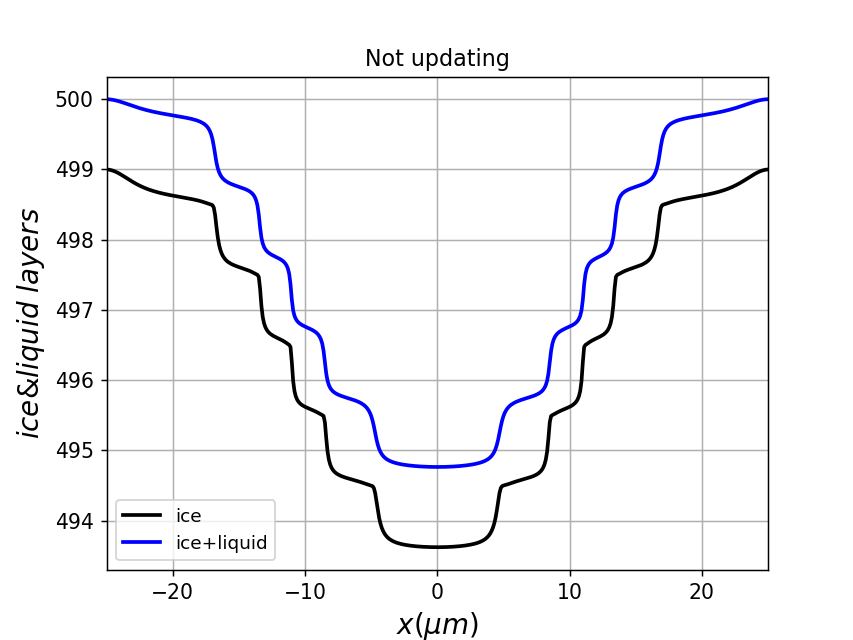

<IPython.core.display.Javascript object>


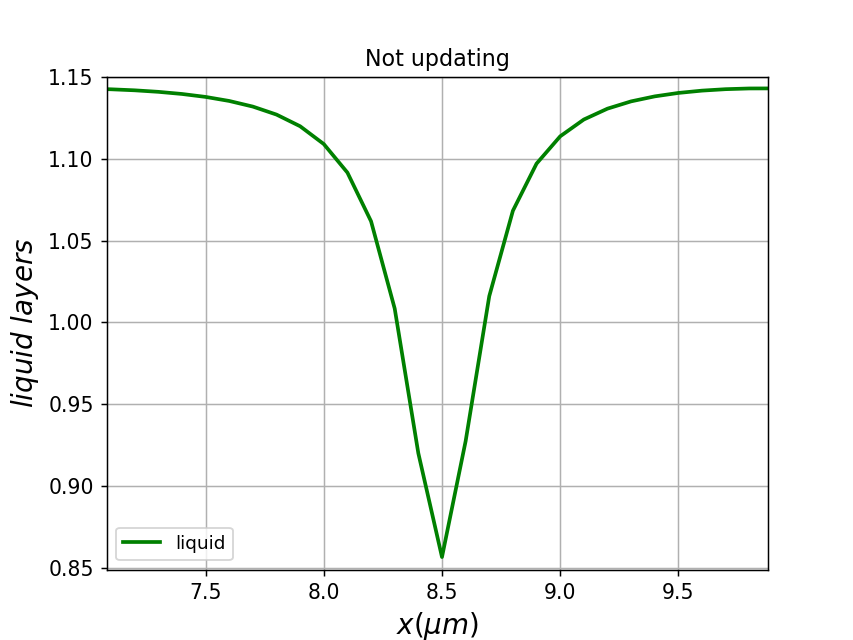

<IPython.core.display.Javascript object>


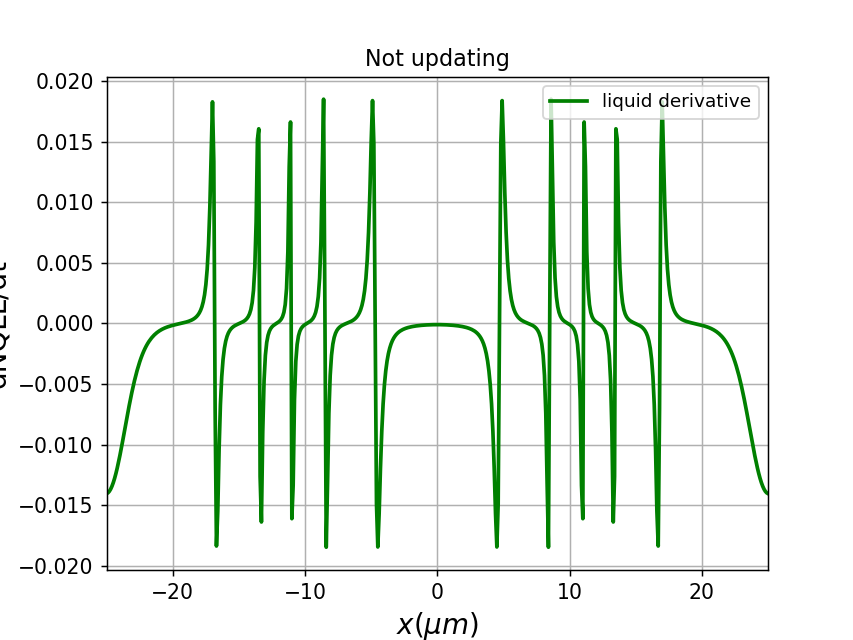

<IPython.core.display.Javascript object>


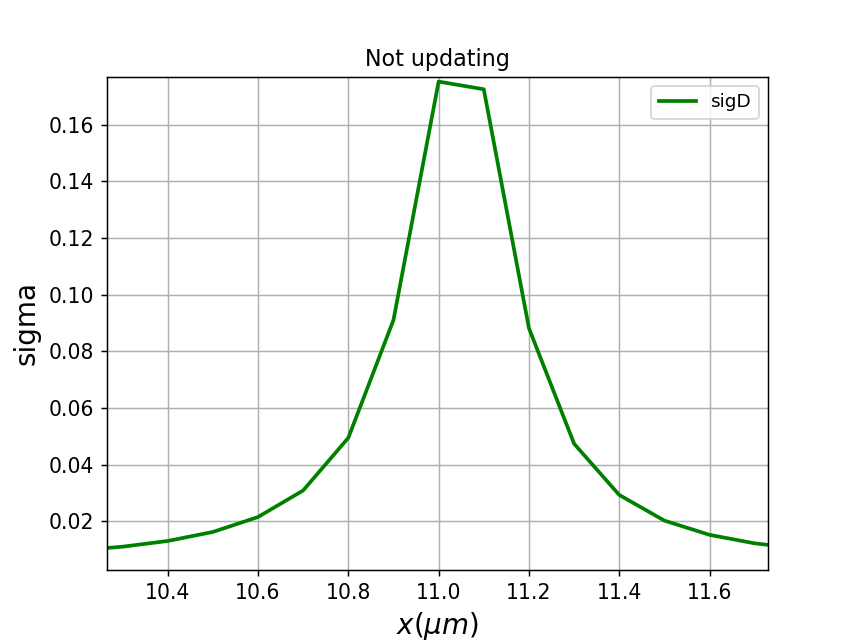

<IPython.core.display.Javascript object>


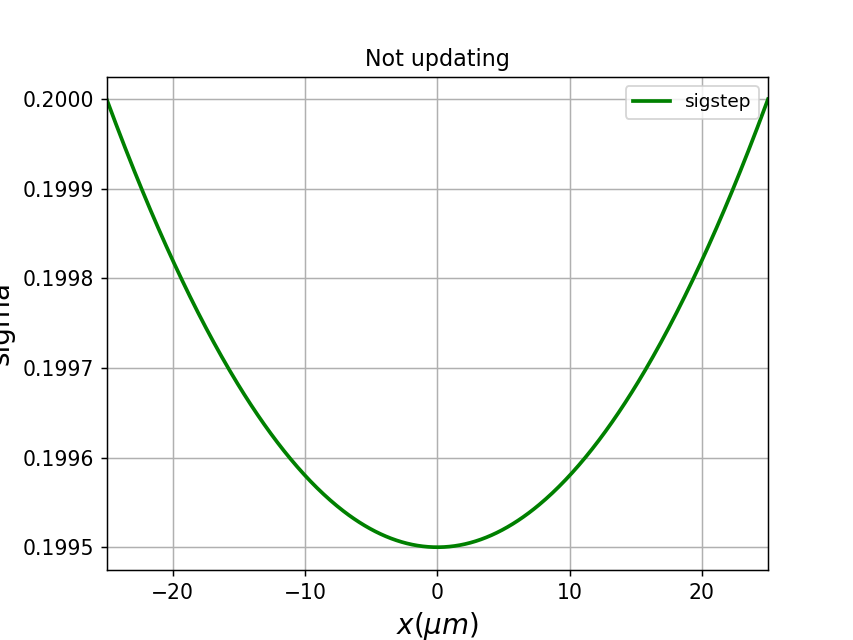

In [13]:
if updatingNQLL:
    title = 'Updating'
else:
    title = 'Not updating'

# Plot ice and liquid
plt.figure()
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, NQLL+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot liquid only
plt.figure()
plt.plot(x-xmid, NQLL, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot derivatives
dydx = ds.f1d(ylast,0,params)
dydx = np.reshape(dydx,(2,nx))
plt.figure()
plt.plot(x-xmid, dydx[0,:], 'g', label='liquid derivative', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('dNQLL/dt',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma
sigD = ds.f1d_sigD(ylast,0,params)
plt.figure()
plt.plot(x-xmid, sigD, 'g', label='sigD', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot sigma
plt.figure()
plt.plot(x-xmid, sigmastep, 'g', label='sigstep', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel('sigma',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

<IPython.core.display.Javascript object>


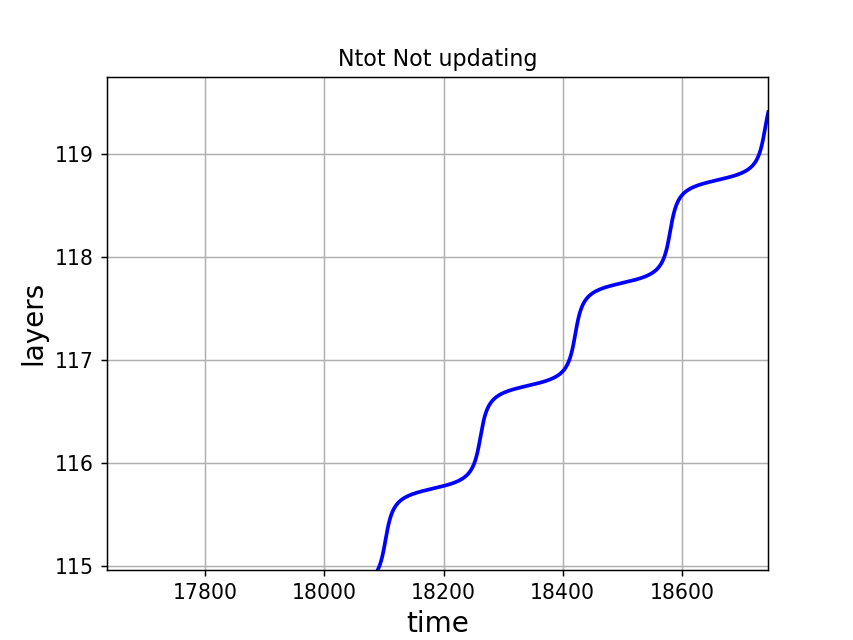

<IPython.core.display.Javascript object>


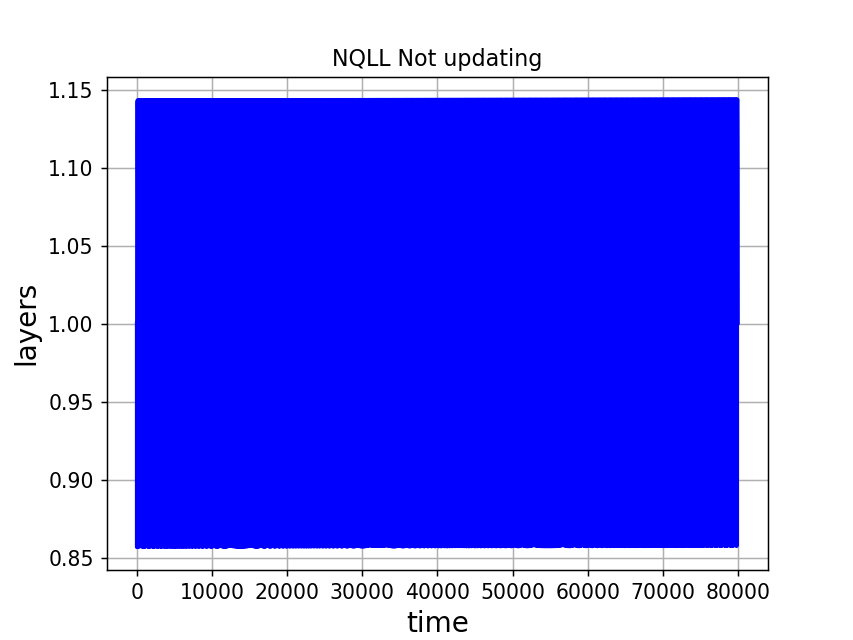

<IPython.core.display.Javascript object>


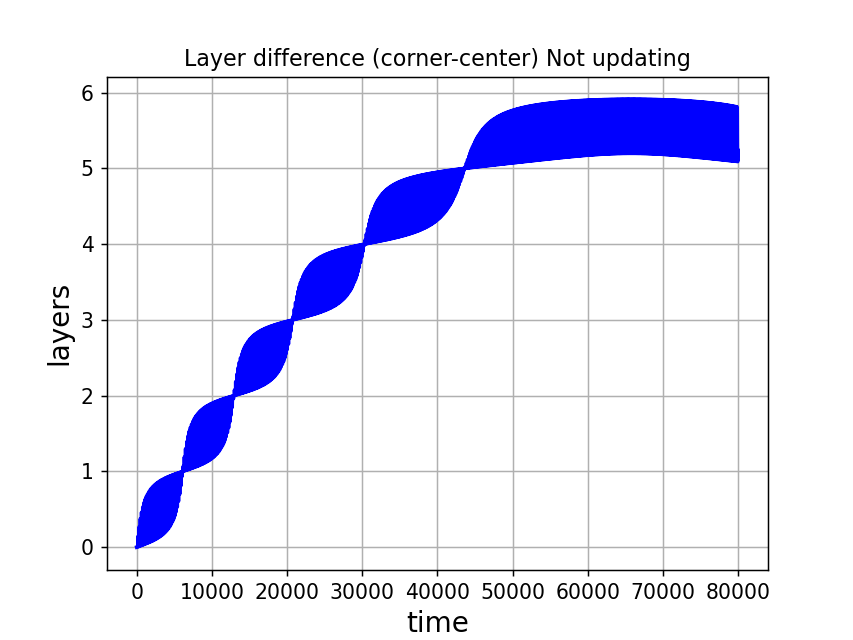

Text(0.5, 1.0, 'Layer difference (corner-center) Not updating')

In [14]:
# The liquid over time
ix = 0
Ntotkeep_at_one_position = np.array(Ntotkeep)[:,ix]
plt.figure()
plt.plot(tkeep, Ntotkeep_at_one_position, 'b', label='total', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('Ntot '+title)

# 
ix = 0
NQLLkeep_at_one_position = np.array(NQLLkeep)[:,ix]
plt.figure()
plt.plot(tkeep, NQLLkeep_at_one_position, 'b', label='liquid', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('NQLL '+title)


Ntot_difference = np.array(Ntotkeep)[:,-1] - np.array(Ntotkeep)[:,nmid]
plt.figure()
plt.plot(tkeep, Ntot_difference, 'b', label='number of steps', lw=linewidth)
plt.xlabel('time',fontsize=fontsize)
plt.ylabel('layers',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.title('Layer difference (corner-center) '+title)

In [23]:
# Some other explorations ... the time required for an initial gaussian to diffuse
t1 = 160; print('Time_to_add_a_layer =', t1)
t2 = 2.5**2/D; print('Time to diffuse across a terrace =', t2)
t3 = 0.2**2/D; print('Time to diffuse into a step =', t3)
t4 = 0.001; print('Time for ice-QLL equilibration =', t4)

Time_to_add_a_layer = 160
Time to diffuse across a terrace = 31250.0
Time to diffuse into a step = 200.00000000000003
Time for ice-QLL equilibration = 0.001
